the preprocessing steps to load the data
1. a quick visualization of the color-space
2. training a simple CNN
3. applying the model to the test data
4. creating the RLE test

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
stage_label = 'stage1'

In [2]:
#read in labels

train_labels = pd.read_csv(os.path.join('./{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
3081,193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a...,"[124996, 12, 125515, 14, 126035, 15, 126555, 1..."
17202,947c0d94c8213ac7aaa41c4efc95d854246550298259cf...,"[49642, 6, 49898, 7, 50154, 8, 50410, 7, 50666..."
17571,9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109...,"[236408, 4, 236926, 7, 237444, 9, 237963, 11, ..."


In [3]:
#load in images
all_images = glob(os.path.join( './stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
21404,./stage1_train/ae570a676961482848b5097038ef5e4...,ae570a676961482848b5097038ef5e407df7a66a8e1c9b...,masks,train,stage1
19538,./stage1_train/a102535b0e88374bea4a1cfd9ee7cb3...,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,masks,train,stage1


In [6]:
#create training data

%time

train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 15 µs


,ImageId,Stage,images,masks
21,07fb37aafa6626608af90c1e18f6a743f29b6b233d2e42...,stage1,"[[[0.2, 0.2, 0.2], [0.223529411765, 0.22352941...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


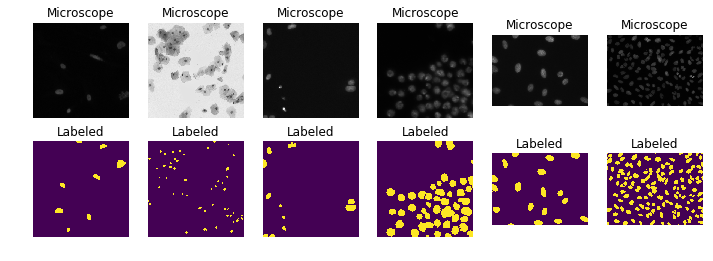

In [8]:
#show images
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

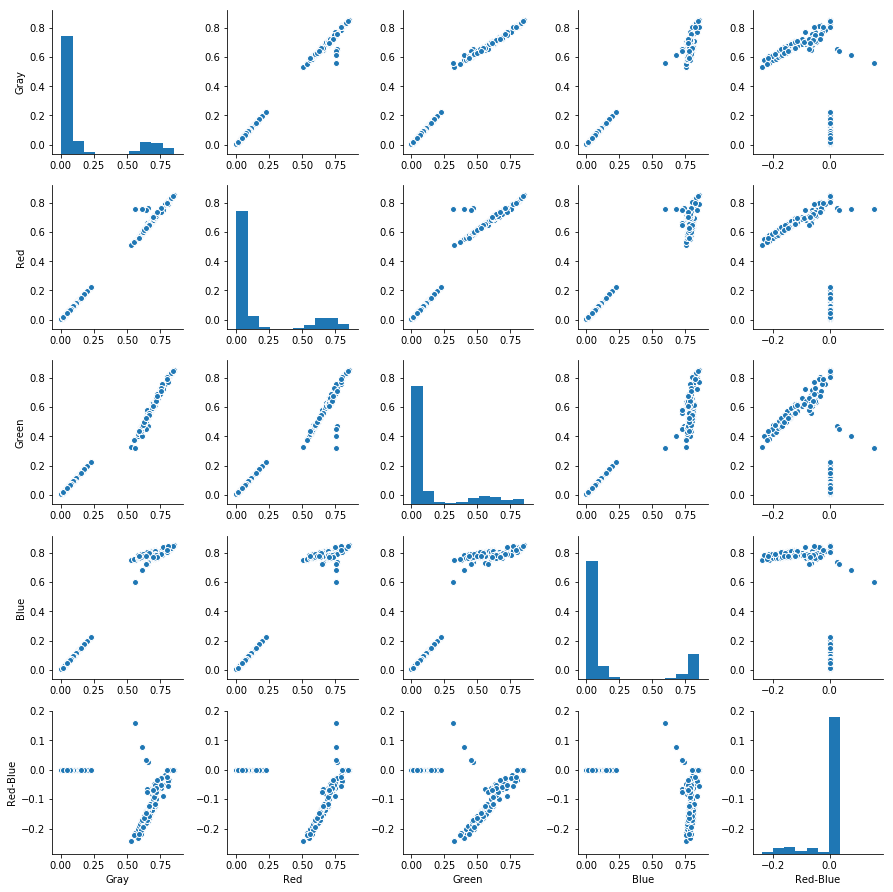

In [9]:
# Look at color intensity distributions


train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

In [10]:
#check dimensions of images


train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

In [11]:
#Make a simple CNN

from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________

In [12]:
# loss function is IoU which is inverse Dice

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

In [14]:
#Here I run a simple training, with each image being it's own batch (not a very good idea), 
# but it keeps the code simple

def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 10)

Epoch 1/10
670/670 [==============================] - 578s 862ms/step - loss: -0.6837 - dice_coef: 0.6837 - acc: 0.8637 - mean_squared_error: 0.1285
Epoch 2/10
670/670 [==============================] - 982s 1s/step - loss: -0.7796 - dice_coef: 0.7796 - acc: 0.9208 - mean_squared_error: 0.0766
Epoch 3/10
670/670 [==============================] - 511s 763ms/step - loss: -0.8012 - dice_coef: 0.8012 - acc: 0.9295 - mean_squared_error: 0.0687
Epoch 4/10
670/670 [==============================] - 546s 815ms/step - loss: -0.8043 - dice_coef: 0.8043 - acc: 0.9312 - mean_squared_error: 0.0675
Epoch 5/10
670/670 [==============================] - 478s 713ms/step - loss: -0.8083 - dice_coef: 0.8083 - acc: 0.9317 - mean_squared_error: 0.0673
Epoch 6/10
670/670 [==============================] - 487s 726ms/step - loss: -0.8096 - dice_coef: 0.8096 - acc: 0.9325 - mean_squared_error: 0.0667
Epoch 7/10
670/670 [==============================] - 502s 749ms/step - loss: -0.8090 - dice_coef: 0.8090 - a

this is obviously a TERRIBLE Model. loss is negative and not monotonic. Learning rate is clearly way too high and that the initializations are insane


In [16]:
# apply model to test

%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 20.3 µs
65 images to process


,ImageId,Stage,images
26,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,stage1,"[[[0.0117647058824, 0.0117647058824, 0.0117647..."


In [17]:
%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


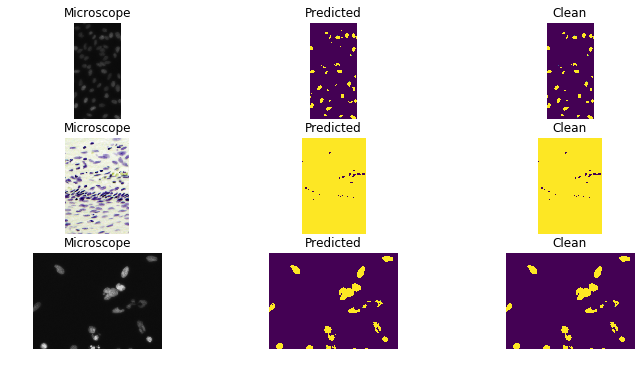

In [18]:
#show a few predictions 

n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

In [19]:
# Check RLE

from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [20]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

In [21]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']


In [22]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))


Matches: 360, Mismatches: 0, Accuracy: 100.0%


In [23]:
#calculate RLES for all masks

test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))


out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1711 regions found for 65 images


,EncodedPixels,ImageId
405,130979 1 131487 2 131497 6 132005 6 132016 9 1...,432f367a4c5b5674de2e2977744d10289a064e5704b21a...
533,14078 3 14332 5 14586 7 14840 9 15096 9 15351 ...,4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d...
1440,33112 3 33630 7 34148 12 34666 16 35185 17 357...,d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...


In [24]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('basiccnn.csv', index = False)